## PU Learning

### What is PU Learning?
PU Learning (Positive-unlabeled learning) is a machine learning scenario for binary classification where the training set consists of a set of **positively-labeled** examples and an **additional unlabeled set** that contains positive and negative examples in unknown proportions.

Compared to normal binary classification where we seperate two sets of data into either `positive` or `negative`, here we only define `positive` and `unlabeled` set.

There are already some fully functional PU learning packages out there, for example [pulearn](https://pulearn.github.io/pulearn/). In this notebook we will try three methods from scratch.

---

### Why PU Learning?

Many practical applications have only positive and unlabeled data. A common simplification used in PU learning is to treat the unlabeled set as if it is negative. **Sometimes this is good enough, but this can be detrimental in many cases**. See the following examploes.

**Fraud Detection**

Suppose we are working on a fraud detection dataset, and we have manually labeled fraud transaction as 1. Can we say that those unlabeled transactions are all non-fraud?

No. We train this model to help us identify unidentifiable fraud, but if only label those identified by human beings as fraud and others as non-fraud, this model can only learn what we've seen in fraudulent transactions.

**Ad Performance**

Another example is when we are looking into ad performance. We've gathered clicked data and associated transactions. Can we simply say that those with low clicks and transactions are of poor quality and should be abandoned?

No. This is because ad performance can be influenced by multiple reasons, such as display slot, total display length, etc. If we treat those with low exposure as poor-performing ads, we might lose some great content that perform bad before.

Instead, what we can do in the previous two examples is to seperate labels into `positive` *(those known cases, or those with sufficient data point)* and unlabeled data. We want to look into the unlabeled data to see which of them are **similar to the positive ones**. By doing so, we can know that they have a high likelihood of being a **positive** case. 


In a nutshell, PU learning is useful if 
1. Negative samples are difficult to collect.
2. Negative samples are of many reasons.

---
### Three ways to deal with PU learning

In the following notebook, we will dive into three different methods to deal with PU learning.

### Preparation

In [73]:
# set up packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 10,8
plt.rcParams['font.size'] = 14

In [61]:
# create dataset
from sklearn.datasets import make_circles
X, y = make_circles(
    n_samples = 10000, noise = 0.1,
    shuffle = True, factor = .7
    )
X = pd.DataFrame(X, columns = ['feature1', 'feature2'])
y = pd.Series(y)

print(f'{X.shape[0]} data points and {X.shape[1]} features')
print(f'{sum(y)} positive out of {len(y)} total')

10000 data points and 2 features
5000 positive out of 10000 total


Currently there are 5000 positive and 5000 negative samples. Here we retrieve only 500 of positive samples, and let the other 9500 samples be **unlabeled**.

In [62]:
# copy original label for later evaluation
y_original = y.copy()

# unlabel several data points
hidden_size = 4500
positive_index = y[y==1].index
y.loc[np.random.choice(positive_index, replace = False, size = hidden_size)] = 0

In [63]:
y.value_counts()

0    9500
1     500
dtype: int64

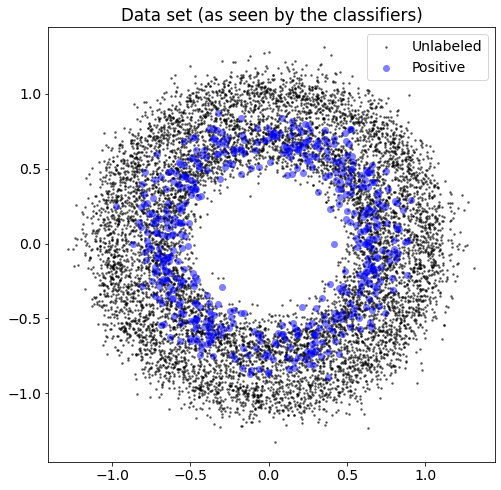

In [77]:
# plot the original data for benchmark
plt.rcParams['figure.figsize'] = 8,8
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Unlabeled'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (as seen by the classifiers)')
plt.show()

### **1. Naive Classification**

The first method is the mostly used one -- to treat unlabeled samples as `negative` ones. As you know this method will create problems stated above. 

This method is stated in KDD 2018 paper [Learning classifiers from only positive and unlabeled data](https://dl.acm.org/doi/10.1145/1401890.1401920). Under certain assumptions (which are sometimes impractical), this method can provide predictions close to actual situation.

In [65]:
# set up models
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=1000, n_jobs=-1
)

rf.fit(X, y)

results = pd.DataFrame({
    'truth': y_original,
    'label': y,
    'output_naive': rf.predict_proba(X)[:,1]},
    columns = ['truth', 'label', 'output_naive']
)

In [66]:
results.sample(10)

,truth,label,output_naive
7664,1,0,0.042
6015,0,0,0.000
6547,0,0,0.000
1266,0,0,0.000
9087,0,0,0.000
5689,0,0,0.000
4317,1,0,0.013
3953,0,0,0.000
4813,0,0,0.000
2199,0,0,0.000


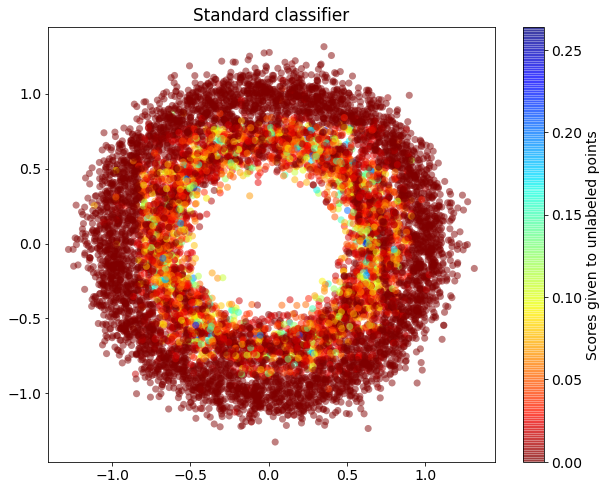

In [75]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_naive, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Standard classifier')
plt.show()

We can see the colorbar on the right -- most of the score are way below 0.2, meaning that these **unlabeled** data are treated as **negative**. This doesn't solve the problem stated above, and it's not an ideal way to solve unlabeled data.

---
### **2. PU Bagging**

PU bagging is a **bootstrap** method that randomly selects a portion of unlabeled data (similar to the number of `positive` cases) as `negative` samples and to build model on. We build different models through multiple iterations, and the final predicted probability is averaged over all the models.  

This method is stated in PRL 2014 paper [A bagging SVM to learn from positive and unlabeled examples](https://www.sciencedirect.com/science/article/abs/pii/S0167865513002432), and in fact it works pretty well especially when positive samples are rare.

In [68]:
from sklearn.tree import DecisionTreeClassifier
n_estimators = 1000 # 1000 trees
estimator = DecisionTreeClassifier()

# keep track of indices of positive and unlabeled data
P_index = y[y > 0].index
U_index = y[y <= 0].index

# keep track of how many iterations performed and aggregated score
nums = pd.DataFrame(np.zeros(y.shape), y.index) 
sums = pd.DataFrame(np.zeros(y.shape), y.index)

# loop through 1000 trees and keep track of the results
for i in range(n_estimators):
    # extract bootstrap samples of unlabeled data for each iteration
    samples = np.random.choice(U_index, replace = True, size = len(P_index))
    
    # track the non-selected indices, which will be used as predictions later
    ind_loop = list(set(U_index)-set(samples))
    
    # fit and predict
    Xb = X[y > 0].append(X.loc[samples])
    yb = y[y > 0].append(y.loc[samples])
    estimator.fit(Xb, yb)
    
    # record the predicted results
    sums.loc[ind_loop, 0] += estimator.predict_proba(X.loc[ind_loop])[:, 1]
    
    # record number of iteration performed
    nums.loc[ind_loop, 0] += 1

results['output_bagging'] = sums / nums

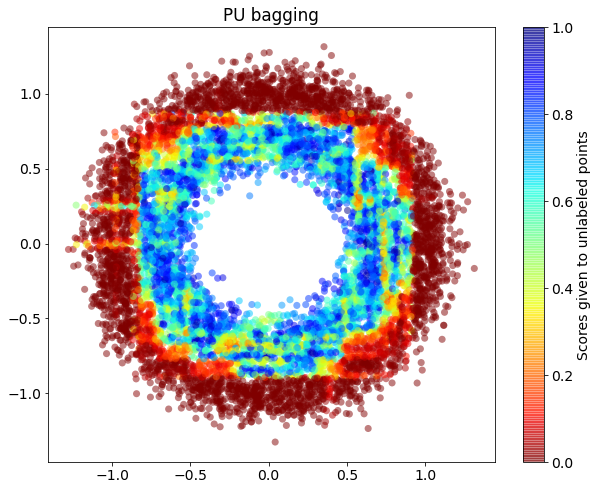

In [76]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_bagging, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU bagging')
plt.show()

Again, we can take a look at the colorbar on the right. This time we see lots of samples have scores higher than 0.5. This means that those data points are more similar to the `positive` samples compared to others. We can see that this method can clearly **help us identify which unlabeled data are more likely to be positive**.

---
### **3. Two-Step Approach**

This is an intuitive approach when dealing with PU learning problems. It consists of the following steps.

1. Manually identify **reliable `negative`** samples, and build models based on those reliable negative and positive samples.
2. Predict unlabeled data based on the model built.
3. Update the dataset by adding more **reliable `negative` and `positive` samples** based on the previous model.
4. Build another model for prediction; iterate these steps until all the unlabeled data can be classified into either one.

This method is stated in the IJCAT journal paper [An Evaluation of Two-Step Techniques for Positive-Unlabeled Learning in Text Classification
](https://www.semanticscholar.org/paper/An-Evaluation-of-Two-Step-Techniques-for-Learning-Kaboutari-Bagherzadeh/96af76b77f3cd8d8b4b3a4c2d17a908507318910?p2df2).

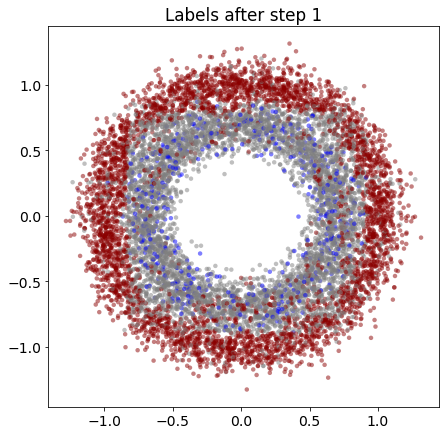

Step 1 labeled 0 new positives and 4174 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 405 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 144 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 111 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 65 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 54 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 35 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 32 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 30 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 36 new negatives.
Doing step 2... 

In [78]:
# Create a new target vector, with 1 for positive, -1 for unlabeled, and 
# 0 for "reliable negative" (there are no reliable negatives to start with)
ys = 2 * y - 1

# Get the scores from before
pred = rf.predict_proba(X)[:,1]

# Find the range of scores given to positive data points
range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]

# STEP 1
# If any unlabeled point has a score above all known positives, 
# or below all known positives, label it accordingly
iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
ys.loc[iP_new] = 1
ys.loc[iN_new] = 0

# Show the results of step 1
plt.rcParams['figure.figsize'] = 7,7
cdict = {-1:'gray', 0:'darkred', 1:'blue'}
plt.scatter(
    X.feature1, X.feature2, 
    c = [cdict[k] for k in ys], 
    linewidth = 0, s = 20, alpha = 0.5
)
plt.title('Labels after step 1')
plt.show()   

# Classifier to be used for step 2
rf2 = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)

# Limit to 10 iterations (this is arbitrary, but 
# otherwise this approach can take a very long time)
for i in range(10):
    # If step 1 didn't find new labels, we're done
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        break
    
    print(
        'Step 1 labeled %d new positives and %d new negatives.' 
        % (len(iP_new), len(iN_new))
    )
    print('Doing step 2... ', end = '')
    
    # STEP 2
    # Retrain on new labels and get new scores
    rf2.fit(X, ys)
    pred = rf2.predict_proba(X)[:,-1]
    
    # Find the range of scores given to positive data points
    range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
    
    # Repeat step 1
    iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
    iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
    ys.loc[iP_new] = 1
    ys.loc[iN_new] = 0
    
    
# Lastly, get the scores assigned by this approach    
results['output_stp'] = pred

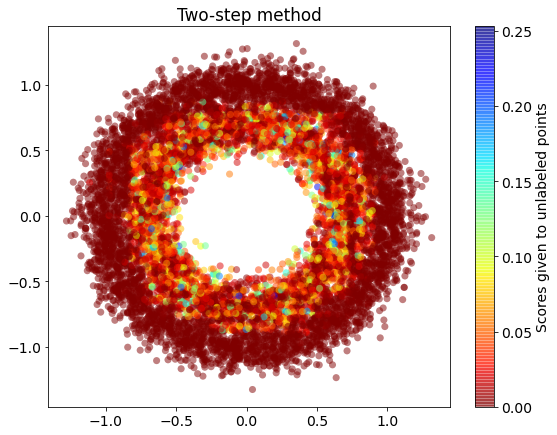

In [79]:
# Visualize this approach's final results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_stp, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

From the previous plot, we can see that the result is slightly better than the naive approach, but still poorer than the bagging approach.

### Comparison of different approaches

We first create another **average version** to add into comparison.

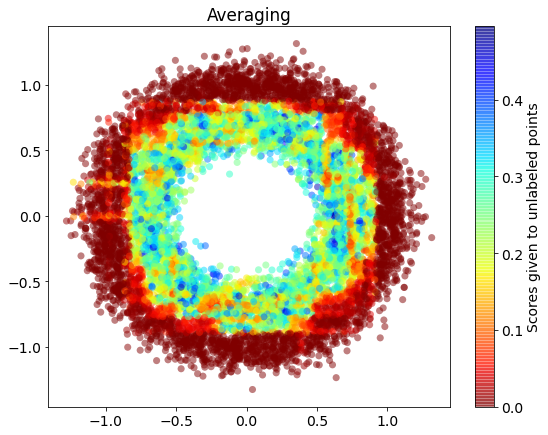

In [81]:
# For each data point, calculate the average score from the three approaches
results['output_all'] = results[[
    'output_naive', 'output_bagging', 'output_stp'
]].mean(axis = 1)

# Visualize average scores
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_all, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Averaging')
plt.show()

In [87]:
# Prepare for graphing the performance 
# (i.e. the success in identifying hidden positives)
ts = range(100, hidden_size, 100)
y_std, y_bag, y_skb, y_stp, y_all = [], [], [], [], []
for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_naive', ascending = False
        ).head(t).truth.mean()
    )
    y_bag.append(
        results[results.label == 0].sort_values(
            'output_bagging', ascending = False
        ).head(t).truth.mean()
    )
    y_stp.append(
        results[results.label == 0].sort_values(
            'output_stp', ascending = False
        ).head(t).truth.mean()
    )
    y_all.append(
        results[results.label == 0].sort_values(
            'output_all', ascending = False
        ).head(t).truth.mean()
    )

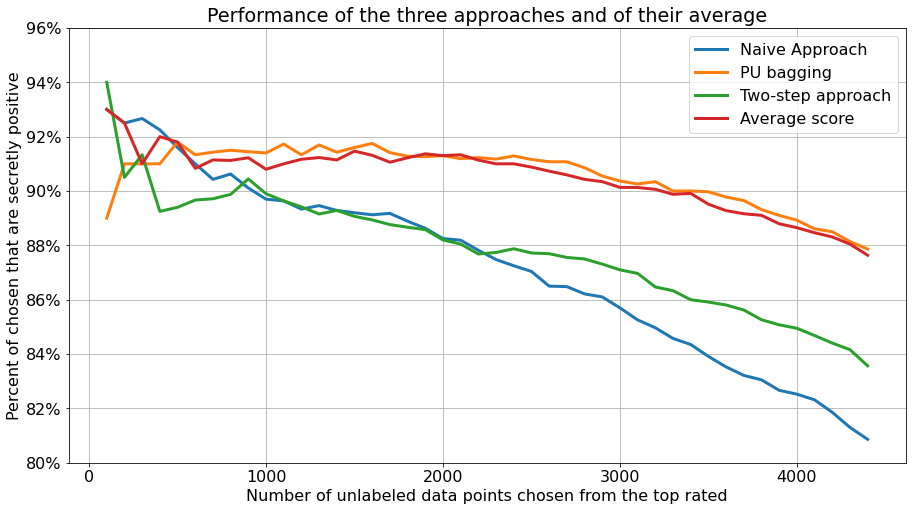

In [86]:
# Performance graphing
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8

plt.plot(
    ts, y_std,
    ts, y_bag,
    ts, y_stp,
    ts, y_all,
    lw = 3
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly positive')
plt.legend([
    'Naive Approach', 
    'PU bagging', 
    'Two-step approach', 
    'Average score'
])
ylim = plt.gca().get_ylim()
plt.title('Performance of the three approaches and of their average')
plt.grid()
plt.show()

From the plot above, we can see that **PU bagging** performs better than **two-step approach**, followed by the **naive approach**.

---
### Effect on different metrics
* **True Positives**: `underestimated`
* **True Negatives**: `overestimated`
* **False Positives**: `overestimated`
* **False Negatives**: `underestimated`
* **Accuracy**: depends on balance and classifier


---

### Reference
https://blog.csdn.net/anshuai_aw1/article/details/89475986

https://stats.stackexchange.com/questions/223956/how-are-performance-measures-affected-in-pu-learning

https://pulearn.github.io/pulearn/